In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

In [17]:
# Specify the file path
train_dataset_path = r'E:\Trading Course\Kaggle\train.csv'
test_dataset_path = r'E:\Trading Course\Kaggle\example_test_files\test.csv'
revealed_targets_dataset_path = r'E:\Trading Course\Kaggle\example_test_files\revealed_targets.csv'
sample_submission_path = r'E:\Trading Course\Kaggle\example_test_files\sample_submission.csv'
    
train_dataset = pd.read_csv(train_dataset_path)
revealed_targets_dataset = pd.read_csv(revealed_targets_dataset_path)
test_dataset = pd.read_csv(test_dataset_path)
sample_submission_dataset = pd.read_csv(sample_submission_path)
                                
train_dataset.shape

(5237980, 17)

In [5]:
train_dataset = train_dataset[train_dataset['date_id'] <= 3]

In [18]:
train_dataset.shape

(5237980, 17)

In [18]:
def calculate_rsi_stochastic_oscillator(df, window_rsi=14, rsi_ma_window = 14, window_kd=14, smooth_d=3):
    # Group by date_id and calculate rolling values within each group
    grouped = df.groupby('date_id')
    
    # Calculate price changes
    #delta = df[(df['stock_id'] == id)]['reference_price'].diff()
    #delta = df['reference_price'].diff()
    #delta = grouped['reference_price'].diff()
    df['delta'] = grouped['reference_price'].transform(lambda x: x.diff())
    
    # Separate gains (positive changes) and losses (negative changes)
    #gains = delta.where(delta > 0, 0)
    #losses = -delta.where(delta < 0, 0)
    df['gains'] = df['delta'].where(df['delta'] > 0, 0)
    df['losses'] = -df['delta'].where(df['delta'] < 0, 0)

    # Calculate average gains and average losses over the specified window
    #avg_gains = gains.rolling(window=window_rsi, min_periods=1).mean()
    #avg_losses = losses.rolling(window=window_rsi, min_periods=1).mean()
    df['avg_gains'] = grouped['gains'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())
    df['avg_losses'] = grouped['losses'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())

    
    # Calculate relative strength (RS)
    # rs = avg_gains / avg_losses
    df['rs'] = df['avg_gains'] / df['avg_losses']
    
    # Calculate the RSI index
    # rsi = 100 - (100 / (1 + rs))
    df['rsi'] = 100 - (100 / (1 + df['rs']))
    
    # Calculate the moving average of RSI
    # rsi_ma = rsi.rolling(window=rsi_ma_window, min_periods=1).mean()
    df['rsi_ma'] = grouped['rsi'].transform(lambda x: x.rolling(window=rsi_ma_window, min_periods=1).mean())
    
    # Calculate Stochastic Oscillator (%K and %D) for a given stock.
    #low_min = df['reference_price'].rolling(window=window_kd, min_periods=1).min()
    #high_max = df['reference_price'].rolling(window=window_kd, min_periods=1).max()
    df['low_min'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).min())
    df['high_max'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).max())

    # Calculate %K
    #percentK = ((df['reference_price'] - low_min) / 
    #                    (high_max - low_min) * 100)
    df['percentK'] = ((df['reference_price'] - df['low_min']) / 
                        (df['high_max'] - df['low_min']) * 100)
    
    # Smooth %K to get %D common choices of smooth_d are 3 or 5. Default is 3
    #percentD = percentK.rolling(window=smooth_d, min_periods=1).mean()
    df['percentD'] = grouped['percentK'].transform(lambda x: x.rolling(window=smooth_d, min_periods=1).max())
    
    #return rsi, rsi_ma, percentK, percentD
    #return df['rsi'], df['rsi_ma'], df['percentK'], df['percentD']

In [7]:
unique_stock_ids = train_dataset['stock_id'].unique()

stock_id = 0
stock_data = train_dataset[train_dataset['stock_id'] == stock_id].copy()
window_rsi=14
rsi_ma_window = 14
window_kd=14
smooth_d=3
grouped = stock_data.groupby('date_id')
stock_data['delta'] = grouped['reference_price'].transform(lambda x: x.diff())

stock_data['gains'] = stock_data['delta'].where(stock_data['delta'] > 0, 0)
stock_data['losses'] = -stock_data['delta'].where(stock_data['delta'] < 0, 0)

stock_data['avg_gains'] = grouped['gains'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())
stock_data['avg_losses'] = grouped['losses'].transform(lambda x: x.rolling(window=window_rsi, min_periods=1).mean())
stock_data['rs'] = stock_data['avg_gains'] / stock_data['avg_losses']
stock_data['rsi'] = 100 - (100 / (1 + stock_data['rs']))
stock_data['rsi_ma'] = grouped['rsi'].transform(lambda x: x.rolling(window=rsi_ma_window, min_periods=1).mean())
stock_data['low_min'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).min())
stock_data['high_max'] = grouped['reference_price'].transform(lambda x: x.rolling(window=window_kd, min_periods=1).max())
#delta = grouped['reference_price'].diff()
#gains = delta.where(delta > 0, 0)
#losses = -delta.where(delta < 0, 0)
stock_data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,delta,gains,losses,avg_gains,avg_losses,rs,rsi,rsi_ma,low_min,high_max
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,NaN,0.000000,-0.000000,0.000000,-0.000000,NaN,NaN,NaN,0.999812,0.999812
191,0,0,10,1299772.70,1,1.000026,15261106.63,NaN,NaN,0.999812,...,0.000214,0.000214,-0.000000,0.000107,-0.000000,-inf,100.000000,100.000000,0.999812,1.000026
382,0,0,20,1299772.70,1,0.999919,15261106.63,NaN,NaN,0.999812,...,-0.000107,0.000000,0.000107,0.000071,0.000036,2.000000,66.666667,83.333333,0.999812,1.000026
573,0,0,30,1299772.70,1,1.000133,15261106.63,NaN,NaN,1.000026,...,0.000214,0.000214,-0.000000,0.000107,0.000027,4.000000,80.000000,82.222222,0.999812,1.000133
764,0,0,40,1218204.43,1,1.000455,15342674.90,NaN,NaN,1.000241,...,0.000322,0.000322,-0.000000,0.000150,0.000021,7.009346,87.514586,83.545313,0.999812,1.000455


In [41]:
grouped['rsi'].transform(lambda x: x.rolling(window=rsi_ma_window, min_periods=1).mean())

0               NaN
191      100.000000
382       83.333333
573       82.222222
764       83.545313
            ...    
41065     38.866845
41256     39.581482
41447     40.333544
41638     42.074229
41829     42.894028
Name: rsi, Length: 220, dtype: float64

In [19]:
from concurrent.futures import ThreadPoolExecutor
import threading
from tqdm import tqdm

lock = threading.Lock()


#def process_stock_date_pair(stock_id, date_id, train_dataset):
#    # print("stock_id = ", stock_id, ", date_id = ", date_id)
#    stock_data = train_dataset[(train_dataset['stock_id'] == stock_id) & (train_dataset['date_id'] == date_id)].copy()
#    stock_data['rsi'], stock_data['rsi_ma'], stock_data['percentK'], stock_data['percentD'] = calculate_rsi_stochastic_oscillator(stock_data, window_rsi=14, rsi_ma_window=14, window_kd=14, smooth_d=3)
#    return stock_id, date_id, stock_data[['rsi', 'rsi_ma', 'percentK', 'percentD']]

def process_stock_date_pair(stock_id, train_dataset):
    # print("stock_id = ", stock_id)
    stock_data = train_dataset[train_dataset['stock_id'] == stock_id].copy()
    #stock_data['rsi'], stock_data['rsi_ma'], stock_data['percentK'], stock_data['percentD'] = calculate_rsi_stochastic_oscillator(stock_data, window_rsi=14, rsi_ma_window=14, window_kd=14, smooth_d=3)
    calculate_rsi_stochastic_oscillator(stock_data, window_rsi=14, rsi_ma_window=14, window_kd=14, smooth_d=3)
    return stock_id, stock_data[['rsi', 'rsi_ma', 'percentK', 'percentD']]
    
#def update_train_dataset(stock_id, date_id, result_data, train_dataset):
#    with lock:
#        mask = (train_dataset['stock_id'] == stock_id) & (train_dataset['date_id'] == date_id)
#        train_dataset.loc[mask, ['rsi', 'rsi_ma', 'percentK', 'percentD']] = result_data.values

def update_train_dataset(stock_id, result_data, train_dataset):
    with lock:
        mask = (train_dataset['stock_id'] == stock_id)
        train_dataset.loc[mask, ['rsi', 'rsi_ma', 'percentK', 'percentD']] = result_data.values


#def parallelize_processing(unique_stock_ids, unique_date_ids, train_dataset):
#    results = []

#    with ThreadPoolExecutor() as executor:
#        # Create a list of tuples containing all combinations of unique_stock_ids and unique_date_ids
#        combinations = [(stock_id, date_id, train_dataset) for stock_id in unique_stock_ids for date_id in unique_date_ids]

#        # Use executor.map to get results in the order they were submitted
#        # results = executor.map(lambda args: process_stock_date_pair(*args), combinations)
#        results = list(tqdm(executor.map(lambda args: process_stock_date_pair(*args), combinations), total=len(combinations)))

#        print("Processing completed. Starting result update.")

#        # Update train_dataset with the results
#        list(tqdm(executor.map(lambda args: update_train_dataset(*args, train_dataset),
#                               [(stock_id, date_id, result_data) for stock_id, date_id, result_data in results]),
#                  total=len(results)))

def parallelize_processing(unique_stock_ids, train_dataset):
    results = []

    with ThreadPoolExecutor() as executor:
        # Create a list of tuples containing unique_stock_ids
        combinations = [(stock_id, train_dataset) for stock_id in unique_stock_ids]

        # Use executor.map to get results in the order they were submitted
        # results = executor.map(lambda args: process_stock_date_pair(*args), combinations)
        #results = list(tqdm(executor.map(lambda args: process_stock_date_pair(*args), combinations), total=len(combinations)))
        results = list(tqdm(executor.map(lambda stock_id: process_stock_date_pair(stock_id, train_dataset), unique_stock_ids), total=len(unique_stock_ids)))
        #results = list(tqdm(executor.map(process_stock_date_pair, unique_stock_ids, train_dataset), total=len(unique_stock_ids)))

        print("Processing completed. Starting result update.")

        # Update train_dataset with the results
        list(tqdm(executor.map(lambda args: update_train_dataset(*args, train_dataset),
                               [(stock_id, result_data) for stock_id, result_data in results]),
                  total=len(results)))


# Get unique stock and date IDs
unique_stock_ids = train_dataset['stock_id'].unique()
# unique_date_ids = train_dataset['date_id'].unique()

# Parallelize the processing
# parallelize_processing(unique_stock_ids, unique_date_ids, train_dataset)
parallelize_processing(unique_stock_ids, train_dataset)


# Print or further analyze the updated DataFrame



100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [02:36<00:00,  1.28it/s]


Processing completed. Starting result update.


100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:04<00:00, 46.93it/s]


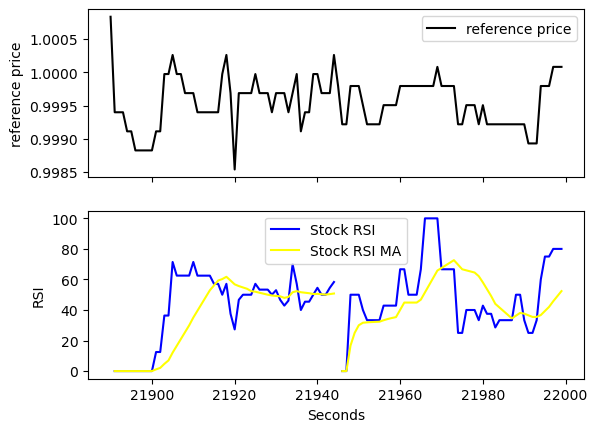

In [26]:
# Create a figure and two subplots with a shared X-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

test_date_id = 400
test_stock_id = 120

flag_date = (train_dataset['date_id'] > test_date_id-3) & (train_dataset['date_id'] < test_date_id)

# Plot data on the first subplot
ax1.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['reference_price'], label='reference price', color='black')
ax1.set_ylabel('reference price')
ax1.legend()

# Plot data on the second subplot
ax2.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['rsi'], label='Stock RSI', color='blue')
ax2.plot(train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['time_id'], train_dataset[(flag_date)&(train_dataset['stock_id'] == test_stock_id)]['rsi_ma'], label='Stock RSI MA', color='yellow')
ax2.set_xlabel('Seconds')
ax2.set_ylabel('RSI')
ax2.legend()

# Show the plot
plt.show()

In [21]:
train_dataset.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price,ask_size,wap,target,time_id,row_id,rsi,rsi_ma,percentK,percentD
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,...,1.000026,8493.03,1.0,-3.029704,0,0_0_0,NaN,NaN,NaN,NaN
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,...,1.000660,20605.09,1.0,-5.519986,0,0_0_1,NaN,NaN,NaN,NaN
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,...,1.000298,18995.00,1.0,-8.389950,0,0_0_2,NaN,NaN,NaN,NaN
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,...,1.000214,479032.40,1.0,-4.010200,0,0_0_3,NaN,NaN,NaN,NaN
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,...,1.000016,434.10,1.0,-7.349849,0,0_0_4,NaN,NaN,NaN,NaN


In [ ]:
def log_return(list_stock_prices):
    """收益率
    """
    return np.log(list_stock_prices).diff()


def realized_volatility(series_log_return):
    """波动率
    """
    return np.sqrt(np.sum(series_log_return**2))


def fix_jsonerr(df):
    """
    """
    df.columns = [
        "".join(c if c.isalnum() else "_" for c in str(x)) for x in df.columns
    ]
    return df


def feature_row(book):
    """
    """
    # book_wap1 生成标签
    for i in [
            1,
            2,
    ]:
        # wap
        book[f'book_wap{i}'] = (book[f'bid_price{i}'] * book[f'ask_size{i}'] +
                                book[f'ask_price{i}'] *
                                book[f'bid_size{i}']) / (book[f'bid_size{i}'] +
                                                         book[f'ask_size{i}'])

    # mean wap
    book['book_wap_mean'] = (book['book_wap1'] + book['book_wap2']) / 2

    # wap diff
    book['book_wap_diff'] = book['book_wap1'] - book['book_wap2']

    # other orderbook features
    book['book_price_spread'] = (book['ask_price1'] - book['bid_price1']) / (
        book['ask_price1'] + book['bid_price1'])
    book['book_bid_spread'] = book['bid_price1'] - book['bid_price2']
    book['book_ask_spread'] = book['ask_price1'] - book['ask_price2']
    book['book_total_volume'] = book['ask_size1'] + book['ask_size2'] + book[
        'bid_size1'] + book['bid_size2']
    book['book_volume_imbalance'] = (book['ask_size1'] + book['ask_size2']) - (
        book['bid_size1'] + book['bid_size2'])
    return book


def feature_agg(book, trade):
    """
    """
    # 聚合生成特征
    book_feats = book.columns[book.columns.str.startswith('book_')].tolist()
    trade_feats = ['price', 'size', 'order_count', 'seconds_in_bucket']

    trade = trade.groupby(['time_id', 'stock_id'])[trade_feats].agg(
        ['sum', 'mean', 'std', 'max', 'min']).reset_index()

    book = book.groupby(['time_id', 'stock_id'])[book_feats].agg(
        [lambda x: realized_volatility(log_return(x))]).reset_index()

    # 修改特征名称
    book.columns = ["".join(col).strip() for col in book.columns.values]
    trade.columns = ["".join(col).strip() for col in trade.columns.values]
    df_ret = book.merge(trade, how='left', on=['time_id', 'stock_id'])
    return df_ret


In [9]:
# Specify the path and filename for the new CSV file
output_csv_path = r'E:\Trading Course\Kaggle\train_withRSIandKD.csv'

# Write the DataFrame to the CSV file
train_dataset.to_csv(output_csv_path, index=False)

In [ ]:
# Create a figure and two subplots with a shared X-axis
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

test_date_id = 9
test_stock_id = 0

# Plot data on the first subplot
ax1.plot(train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['seconds_in_bucket'], train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['reference_price'], label='reference price', color='black')
ax1.set_ylabel('reference price')
ax1.legend()

# Plot data on the second subplot
ax2.plot(train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['seconds_in_bucket'], train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['rsi'], label='Stock RSI', color='blue')
ax2.plot(train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['seconds_in_bucket'], train_dataset[(train_dataset['date_id'] == test_date_id)&(train_dataset['stock_id'] == test_stock_id)]['rsi_ma'], label='Stock RSI MA', color='yellow')
ax2.set_xlabel('Seconds')
ax2.set_ylabel('RSI')
ax2.legend()

# Show the plot
plt.show()



In [ ]:
def calculate_rsi(group, window=14, rsi_ma_window=14):
    delta = group['reference_price'].diff()
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)
    
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()
    
    rs = avg_gains / avg_losses
    rsi = 100 - (100 / (1 + rs))
    rsi_ma = rsi.rolling(window=rsi_ma_window, min_periods=1).mean()
    
    group['rsi'] = rsi
    group['rsi_ma'] = rsi_ma
    
    return group

# Assuming your DataFrame is sorted by 'stock_id' and 'date_id' for proper groupby and apply operations
train_dataset.sort_values(['stock_id', 'date_id'], inplace=True)

# Applying the code to update 'rsi' and 'rsi_ma'
train_dataset = train_dataset.groupby(['stock_id', 'date_id'], group_keys=False).apply(
    lambda group: calculate_rsi(group.copy(), window=14, rsi_ma_window=14)
)

# Resetting index after groupby operation
train_dataset.reset_index(drop=True, inplace=True)

In [ ]:
def calculate_rsi_np(reference_price, window=14, rsi_ma_window=14):
    # Calculate price changes
    delta = np.diff(reference_price)

    # Prepend a NaN value to delta
    delta = np.concatenate(([np.nan], delta))
    
    # Separate gains (positive changes) and losses (negative changes)
    gains = np.where(delta > 0, delta, 0)
    losses = np.where(delta < 0, -delta, 0)

    # Calculate average gains and average losses over the specified window
    cumsum_gains = np.cumsum(gains)
    cumsum_gains[window:] = cumsum_gains[window:] - cumsum_gains[:-window]
    cumsum_losses = np.cumsum(losses)
    cumsum_losses[window:] = cumsum_losses[window:] - cumsum_losses[:-window]
    
    weights = np.concatenate((np.arange(1, window), np.full(len(reference_price) - window + 1, window)))

    avg_gains = cumsum_gains / weights
    avg_losses = cumsum_losses / weights

    # Calculate relative strength (RS)
    # rs = avg_gains / avg_losses
    # Use np.where to handle division by zero and assign 50
    rs = np.nan_to_num(np.divide(avg_gains, avg_losses, where=avg_losses != 0, casting='same_kind'), nan=50)
    rs = np.where((avg_gains >= 0) & (avg_losses == 0), np.inf, rs)
    rs = np.where((avg_gains < 0) & (avg_losses == 0), -np.inf, rs)

    # Calculate the RSI index
    rsi = 100 - (100 / (1 + rs))

    # Calculate the moving average of RSI
    cumsum_rsi_ma = np.cumsum(rsi)
    cumsum_rsi_ma[window:] = cumsum_rsi_ma[window:] - cumsum_rsi_ma[:-window]
    
    rsi_ma = cumsum_rsi_ma / weights

    return rsi, rsi_ma

# Assuming train_dataset is a DataFrame
unique_stock_ids = train_dataset['stock_id'].unique()
unique_date_ids = train_dataset['date_id'].unique()

for stock_id in unique_stock_ids:
    print("stock_id = ",stock_id)
    for date_id in unique_date_ids:
        mask = (train_dataset['stock_id'] == stock_id) & (train_dataset['date_id'] == date_id)
        reference_price = train_dataset[mask]['reference_price'].values
        rsi, rsi_ma = calculate_rsi_np(reference_price, window=14, rsi_ma_window=14)
        train_dataset.loc[mask, 'rsi'] = rsi
        train_dataset.loc[mask, 'rsi_ma'] = rsi_ma
        

In [ ]:
def calculate_rsi(df, window=14, rsi_ma_window = 14):
    # Calculate price changes
    #delta = df[(df['stock_id'] == id)]['reference_price'].diff()
    delta = df['reference_price'].diff()
    
    # Separate gains (positive changes) and losses (negative changes)
    gains = delta.where(delta > 0, 0)
    losses = -delta.where(delta < 0, 0)

    # Calculate average gains and average losses over the specified window
    avg_gains = gains.rolling(window=window, min_periods=1).mean()
    avg_losses = losses.rolling(window=window, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gains / avg_losses

    # Calculate the RSI index
    rsi = 100 - (100 / (1 + rs))

    # Calculate the moving average of RSI
    rsi_ma = rsi.rolling(window=rsi_ma_window, min_periods=1).mean()

    return rsi, rsi_ma

In [ ]:
unique_stock_ids = train_dataset['stock_id'].unique()
unique_date_ids = train_dataset['date_id'].unique()
# Create an empty list to store modified stock_data DataFrames
modified_dataframes = []
# Outer loop
for stock_id in unique_stock_ids:
    print("stock_id = ", stock_id)
    # Inner loop
    for date_id in unique_date_ids:
        stock_data = train_dataset[(train_dataset['stock_id'] == stock_id) & (train_dataset['date_id'] == date_id)].copy()
        stock_data['rsi'], stock_data['rsi_ma'] = calculate_rsi(stock_data, window=14, rsi_ma_window=14)
        modified_dataframes.append(stock_data)

# Update train_dataset outside of the inner loop
for modified_dataframe in modified_dataframes:
    train_dataset.loc[
        (train_dataset['stock_id'] == modified_dataframe['stock_id'].iloc[0]) &
        (train_dataset['date_id'] == modified_dataframe['date_id'].iloc[0]),
        ['rsi', 'rsi_ma']
    ] = modified_dataframe[['rsi', 'rsi_ma']]

In [ ]:
unique_stock_ids = train_dataset['stock_id'].unique()
unique_date_ids = train_dataset['date_id'].unique()

#my_stock_list = [0]
#my_date_list = [0,1]


for stock_id in unique_stock_ids:
    print("stock_id = ", stock_id)
    for date_id in unique_date_ids:
        #print("date_id = ", date_id)
        stock_data = train_dataset[(train_dataset['stock_id'] == stock_id)&(train_dataset['date_id'] == date_id)].copy()  # Create a copy to avoid modifying the original DataFrame
        #print("stock_data.shape before = ", stock_data.shape)
        stock_data['rsi'], stock_data['rsi_ma'], stock_data['percentK'], stock_data['percentD'] = calculate_rsi_stochastic_oscillator(stock_data, window_rsi=14, rsi_ma_window = 14, window_kd=14, smooth_d=3)
        #print("stock_data.shape after = ", stock_data.shape)
        train_dataset.loc[(train_dataset['stock_id'] == stock_id)&(train_dataset['date_id'] == date_id), ['rsi', 'rsi_ma']] = stock_data[['rsi', 'rsi_ma', 'percentK', 'percentD']]
